In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from typing import List
import pandas as pd
from scipy.stats import binom
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binom

from HMC import HMC
import sys
sys.path.append("..")
from MCMC_DZ.BayesianInference.Dian_Likelihood_functions.Periodic_Function import Periodic_Func2D
from MCMC_DZ.MCMC.Statistic_tools import auto_corr_plot, targetDis_step_plot, densities_plot

# 1D Poisson

In [2]:
# Generate synthetic datasets
np.random.seed(42)
num_datasets = 1
lambda_value = 5  # Set the fixed lambda value
poisson_datasets = [np.random.poisson(lambda_value, 100) for _ in range(num_datasets)]

In [3]:
def pdf_poisson(data, lam):
    return poisson.pmf(data, lam)

def logpdf_poisson(data, lam):
    return poisson.logpmf(data, lam)

def log_likelihoods_poisson(params):
    '''
    Pass this function to MCMCs so that parmameters can be inputted.
    Calculates the total log-likelihood of the Gaussian Mixture Model for the given parameter.
    
        The likelihood is calculated as the product of individual pdfs at the observed samples:
        L(θ) = p(x_1, x_2, ..., x_N|θ) = Π_j=1^N p(x_j|θ)

        Since likelihood of each point may be very small, leading to extremely small products, 
        a log likelihood is often used in practice:
        logL(θ) = Σ_j=1^N log(p(x_j|θ)) 

    Arguments
    params [list]: flattened 1D list containing the mean and covariance for each Gaussian component
                    in shape of [mean1, mean2, ..., meanK, cov11, cov12, ..., cov1D, cov21, cov22, ..., covK1, ..., covKD]
                    where K is the number of components, and D is the number of dimensions.
    
    Returns
    log_likelihoods [np.array]: log-likelihood from parameters

    '''
    # t_start = time.process_time()

    n_dims = 1
    n_comp = 1
    
    # reshape the 1D parameter list into mean and covariance matrices for each component
    lam = np.reshape(params[:n_dims*n_comp], (n_comp, n_dims))
        
    # initialize a numpy array of zeros to store log-likelihoods of each sample
    log_likelihoods = 0 

    likelihood = 0
    for j in range(n_comp):
        # calculate log-likelihood of each sample by
        # adding product of mixture coefficient and pdf at sample x_j for each Gaussian component k
        log_likelihoods += logpdf_poisson(poisson_datasets, lam=lam)
    # log_likelihoods += np.log(likelihood) # store in log_likelihoods numpy array

    # t_stop = time.process_time()
    # print("Elapsed time calculating LLH in seconds =", t_stop - t_start)
    
    return np.sum(log_likelihoods)

In [4]:
def dfdx(mu):
    '''
    Forward differencing scheme
    '''
    epsilon = 0.01
    n_dims = 1
    n_comp = 1
    mu = np.array(mu)
    delta_theta = []
    res_mu_plus = []
    for i in range(mu.shape[0]):
        E_plus = np.zeros(n_dims*n_comp)
        E_plus += [(epsilon if j == i else 0) for j in range(n_dims*n_comp)]
        res_mu_plus.append(E_plus)

    for i in range(n_dims*n_comp):
        delta_thetai = (log_likelihoods_poisson(mu+res_mu_plus[i]) - log_likelihoods_poisson(mu))/(epsilon)
        delta_theta.append(delta_thetai)
        
    return delta_theta

In [5]:
def U(theta: List[np.longdouble]) -> np.longdouble:
    '''
    the potential energy function: 
    U(theta) = -log(probability distribution of theta)
    '''
    return - log_likelihoods_poisson(theta)

def grad_U(theta: List[np.longdouble]) -> np.longdouble:
    '''
    the derivative of the potential energy function
    dU/dmu
    '''
    DRho = dfdx(theta)
    Rho = - log_likelihoods_poisson(theta)
    return np.array([dRho/Rho for dRho in DRho])

In [6]:
theta_accept, theta_reject = HMC(epoch=2000, L=20, epsilon=0.01, U=U, grad_U=grad_U, current_theta=np.array([1]))

In [7]:
len(theta_accept)

1441

(array([ 3., 14., 15., 16., 13., 15.,  8.,  7.,  5.,  4.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

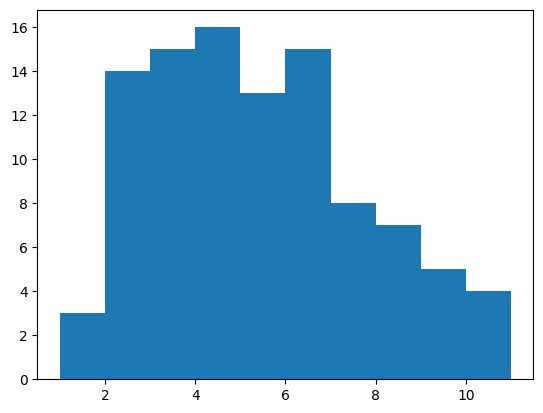

In [8]:
plt.hist(poisson_datasets)

Text(0, 0.5, 'Probability')

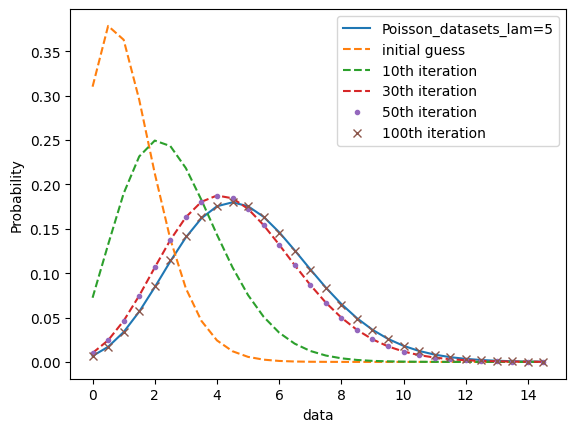

In [9]:
x = np.arange(0, 15, 0.5)
 
# poisson distribution data for y-axis
y = pdf_poisson(x, lam=5)

plt.plot(x,y,label='Poisson_datasets_lam=5')
plt.plot(x,pdf_poisson(x, lam=theta_accept[0][0]), '--',label='initial guess')
plt.plot(x,pdf_poisson(x, lam=theta_accept[9][0]), '--',label='10th iteration')
plt.plot(x,pdf_poisson(x, lam=theta_accept[29][0]), '--',label='30th iteration')
plt.plot(x,pdf_poisson(x, lam=theta_accept[29][0]), '.',label='50th iteration')
plt.plot(x,pdf_poisson(x, lam=theta_accept[99][0]), 'x',label='100th iteration')
plt.legend()
plt.xlabel('data')
plt.ylabel('Probability')

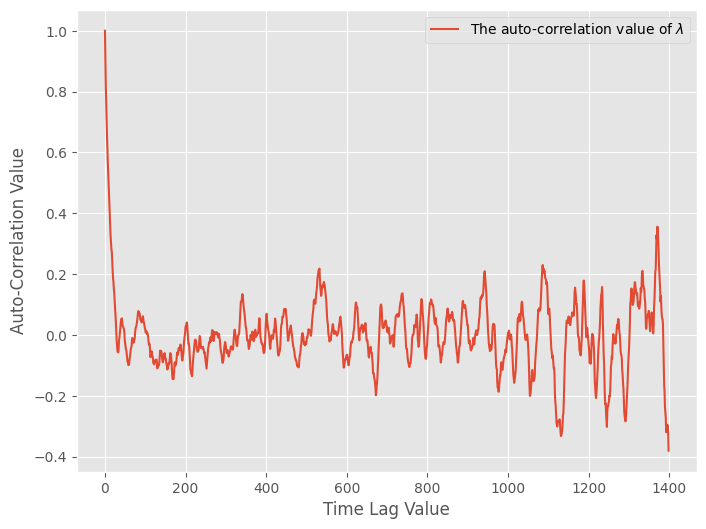

In [10]:
auto_corr_plot(theta_accept, plot_nth_theta=[0],theta_index=['$\lambda$'],max_time_lag=1400,figsize=[8,6])

In [11]:
neglogLikeli = []
for i in theta_accept:
    neglogLikeli.append(-log_likelihoods_poisson(i))

Text(0, 0.5, 'neglogLikeli')

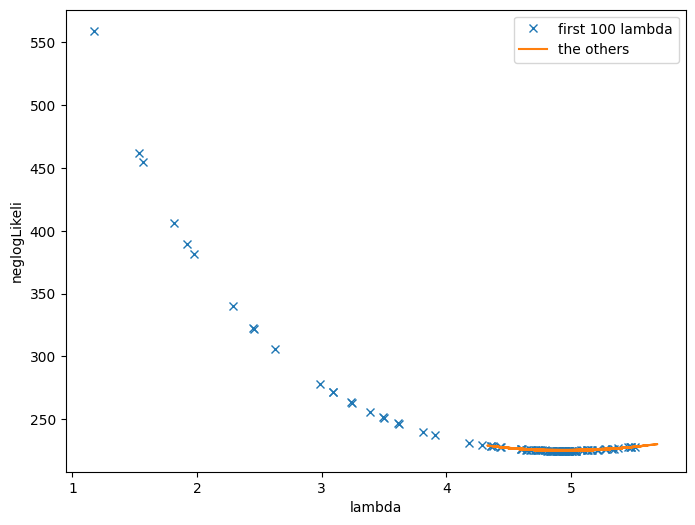

In [12]:
plt.plot(theta_accept[:100], neglogLikeli[:100], 'x', label='first 100 lambda')
plt.plot(theta_accept[100:], neglogLikeli[100:], '-', label='the others')
plt.xlabel('lambda')
plt.legend()
plt.ylabel('neglogLikeli')

In [ ]:
densities_plot(np.array([theta_accept]),plot_axis=[],bins=10,burn_in=100)

# Binomial

In [2]:
# Generate synthetic data from a Binomial distribution with fixed n and p values
np.random.seed(42)
true_n = 20
true_p = 0.3
num_samples = 100
binom_datasets = np.random.binomial(true_n, true_p, num_samples)

In [49]:
def pdf_binomial(data, n, p):
    return binom.pmf(data, n, p)

def logpdf_binomial(data, n, p):
    return binom.logpmf(data, n, p)

def log_likelihoods_binomial(params):
    '''
    Pass this function to MCMCs so that parmameters can be inputted.
    Calculates the total log-likelihood of the Gaussian Mixture Model for the given parameter.
    
        The likelihood is calculated as the product of individual pdfs at the observed samples:
        L(θ) = p(x_1, x_2, ..., x_N|θ) = Π_j=1^N p(x_j|θ)

        Since likelihood of each point may be very small, leading to extremely small products, 
        a log likelihood is often used in practice:
        logL(θ) = Σ_j=1^N log(p(x_j|θ)) 

    Arguments
    params [list]: flattened 1D list containing the mean and covariance for each Gaussian component
                    in shape of [mean1, mean2, ..., meanK, cov11, cov12, ..., cov1D, cov21, cov22, ..., covK1, ..., covKD]
                    where K is the number of components, and D is the number of dimensions.
    
    Returns
    log_likelihoods [np.array]: log-likelihood from parameters

    '''
    # t_start = time.process_time()

    n_dims = 1
    n_comp = 1
    n = 20
    
    # reshape the 1D parameter list into mean and covariance matrices for each component
    # params = np.reshape(params[:n_dims*n_comp], (n_comp, n_dims))
    p = params
        
    # initialize a numpy array of zeros to store log-likelihoods of each sample
    log_likelihoods = 0 

    likelihood = 0
    for j in range(n_comp):
        # calculate log-likelihood of each sample by
        # adding product of mixture coefficient and pdf at sample x_j for each Gaussian component k
        log_likelihoods += logpdf_binomial(binom_datasets, n=n, p=p)
    # log_likelihoods += np.log(likelihood) # store in log_likelihoods numpy array

    for i in range(len(log_likelihoods)):
        if log_likelihoods[i] == float('-inf'):
            log_likelihoods[i] = 0

    # t_stop = time.process_time()
    # print("Elapsed time calculating LLH in seconds =", t_stop - t_start)
    
    return np.sum(log_likelihoods)

In [46]:
def dfdx(mu):
    '''
    Forward differencing scheme
    '''
    epsilon_p = 0.001
    n_dims = 1
    n_comp = 1
    mu = np.array(mu)
    delta_theta = []
    res_mu_plus = []
    for i in range(mu.shape[0]):
        E_plus = np.zeros(n_dims*n_comp)
        E_plus += [(epsilon_p if i == 0 and j == 1 else 0) for j in range(n_dims*n_comp)]
        E_plus += [(epsilon_p if i == j == 1 else 0) for j in range(n_dims*n_comp)]
        res_mu_plus.append(E_plus)

    for i in range(n_dims*n_comp):
        delta_thetai = (log_likelihoods_binomial(mu+res_mu_plus[i]) - log_likelihoods_binomial(mu))/(epsilon_n)
        delta_theta.append(delta_thetai)
        
    return delta_theta

In [47]:
def U(theta: List[np.longdouble]) -> np.longdouble:
    '''
    the potential energy function: 
    U(theta) = -log(probability distribution of theta)
    '''
    return - log_likelihoods_binomial(theta)

def grad_U(theta: List[np.longdouble]) -> np.longdouble:
    '''
    the derivative of the potential energy function
    dU/dmu
    '''
    DRho = dfdx(theta)
    Rho = - log_likelihoods_binomial(theta)
    return np.array([dRho/Rho for dRho in DRho])

In [53]:
theta_accept, theta_reject = HMC(epoch=1000, L=20, epsilon=0.001, U=U, grad_U=grad_U, current_theta=np.array([0.1]))

In [57]:
len(theta_accept)

544

(array([ 1.,  3.,  9., 16., 17., 19., 15.,  9.,  7.,  4.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

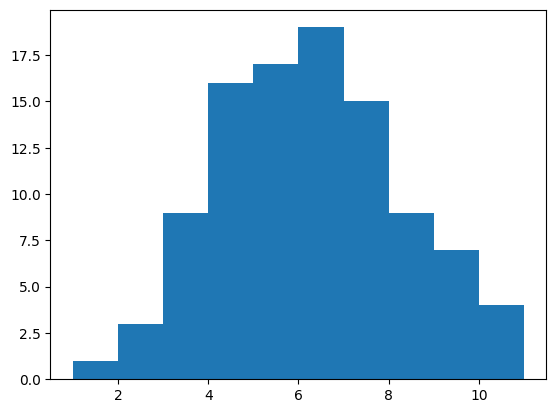

In [56]:
plt.hist(binom_datasets)

In [61]:
theta_accept[0]

array([0.10672462])

Text(0, 0.5, 'Probability')

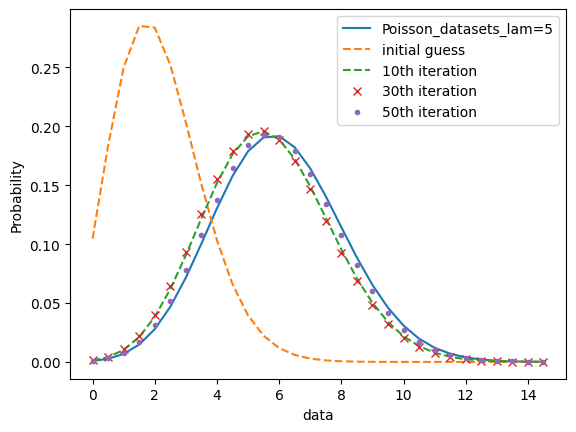

In [65]:
x = np.arange(0, 15, 0.5)
 
# poisson distribution data for y-axis
y = pdf_binomial(x, n=20, p=0.3)

plt.plot(x,y,label='Poisson_datasets_lam=5')
plt.plot(x,pdf_binomial(x, n=20, p=theta_accept[0][0]), '--',label='initial guess')
plt.plot(x,pdf_binomial(x, n=20, p=theta_accept[9][0]), '--',label='10th iteration')
plt.plot(x,pdf_binomial(x, n=20, p=theta_accept[29][0]), 'x',label='30th iteration')
plt.plot(x,pdf_binomial(x, n=20, p=theta_accept[49][0]), '.',label='50th iteration')
plt.legend()
plt.xlabel('data')
plt.ylabel('Probability')

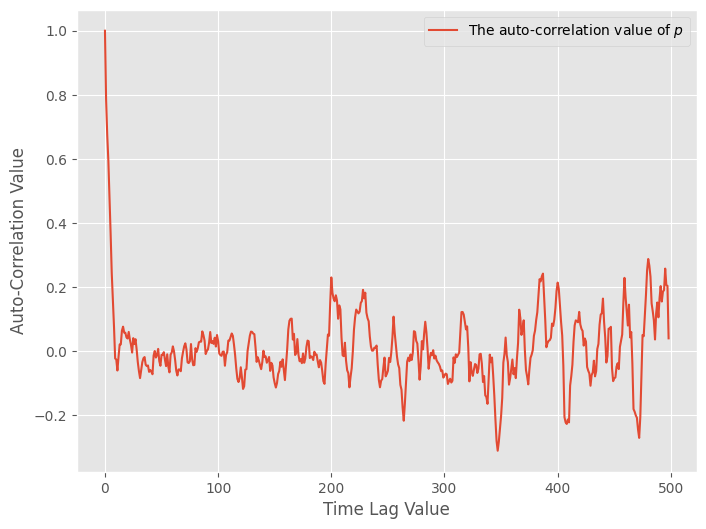

In [67]:
auto_corr_plot(theta_accept, plot_nth_theta=[0],theta_index=['$p$'],max_time_lag=500,figsize=[8,6])

In [70]:
neglogLikeli = []
for i in theta_accept:
    neglogLikeli.append(-log_likelihoods_binomial(i))

Text(0, 0.5, 'neglogLikeli')

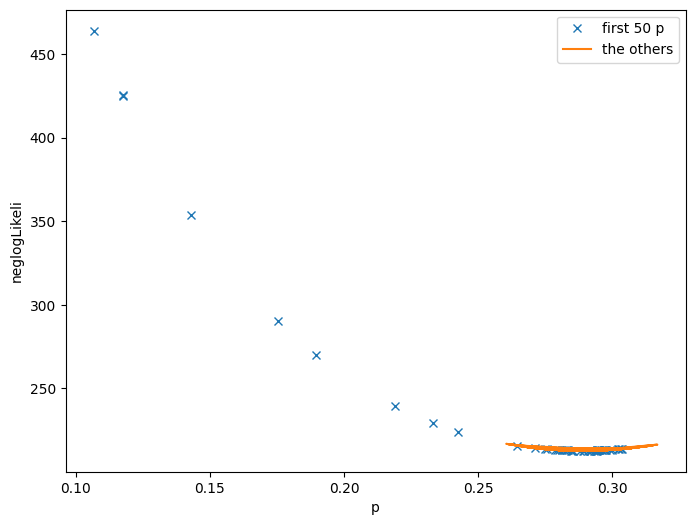

In [71]:
plt.plot(theta_accept[:50], neglogLikeli[:50], 'x', label='first 50 p')
plt.plot(theta_accept[50:], neglogLikeli[50:], '-', label='the others')
plt.xlabel('p')
plt.legend()
plt.ylabel('neglogLikeli')